### 6.28 Inspecting the Price/Volatility data

In [1]:
import os

# data_dir = '/Users/sanch/Dropbox/f2018/CIS693/cis693_ms_project/data'
data_dir = '/home/sanchrob/repos/cis693_ms_project/data'
# fname = os.path.join(data_dir, 'PJM_rt_during.csv')
# fname = os.path.join(data_dir, 'PJM_rt_bomo.csv')
fname = os.path.join(data_dir, 'PJM_rt_before.csv')

f = open(fname)
data = f.read()
f.close()

#lines = data.split('\n')
# splitlines() discards last empty line (universal newlines)
raw_lines = data.splitlines()
header = raw_lines[0].split(',')
lines = raw_lines[1:]

print(header)
print(len(lines))

['"DateTime"', '"Price"', '"Volatility"']
9096


### 6.29 Parsing the data

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    #print(i, line, values)

### 6.30 Plotting the price & volatility timeseries

#### scale plots larger

In [3]:
def scale_plot_size(factor=1.10):
    import matplotlib as mpl
    default_dpi = mpl.rcParamsDefault['figure.dpi']
    mpl.rcParams['figure.dpi'] = default_dpi*factor
    
scale_plot_size()

In [4]:
from matplotlib import pyplot as plt

price = float_data[:, 0]
volatility = float_data[:, 1]

# blue
plt.plot(range(len(price)), price)
# orange
plt.plot(range(len(volatility)), volatility)

### 6.31 Plotting a narrower window of Price/Volatility

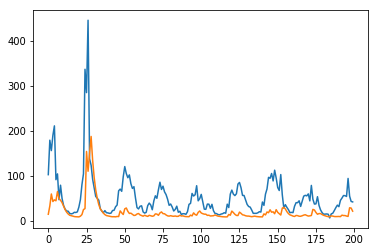

In [5]:
# hourly timesteps, 48 = two days
plt.plot(range(200), price[300:500])
plt.plot(range(200), volatility[300:500])

In [6]:
raw_lines[325]

'"2002-08-14 13:00:00",336.519297,27.5691221021853'

### 6.32 Normalization

In [7]:
# normalize only the training data?
# 120 obs: 50% train, 25% val, 25% test
mean = float_data[:60].mean(axis=0)
float_data -= mean
std = float_data[:60].std(axis=0)
float_data /= std

In [8]:
# get shape of the matrix
float_data.shape

(9096, 2)

### 6.33 Generator for yielding timeseries samples and targets

In [9]:
# lookback = 24; observations will go back 1 day
# steps = 1; observations will be sampled hourly
# delay = 12; targets wil be 12 hours in the future

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=6, step=1):
    
    # only applies to test_gen
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
#     print("init, i: ", i)
      
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                        
            rows = np.arange(i, min(i + batch_size, max_index))
#             print(rows, len(rows))
#             print("i: ", i)
            i += len(rows)
#             print("increment i: ", i)
                
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]  # field [1] is volatility, our response variable
        
        yield samples, targets

* data—The original array of floating-point data, which you normalized in listing 6.32.
* lookback—How many timesteps back the input data should go.
* delay—How many timesteps in the future the target should be.
* min_index and max_index—Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
* shuffle—Whether to shuffle the samples or draw them in chronological order.
* batch_size—The number of samples per batch.
* step—The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour.

### 6.34 Prepare train, validation, test generators

In [10]:
batch_size = 12 # number of samples (of size lookback) per batch
lookback = 48   # sample size (history)
delay = 12      # target (predict n + delay steps from now)
step = 1        # sample frequency (1 = hourly)


# 70%
tr_max_idx = int((len(float_data) * 0.7) // 1) - 1
print("  tr_max_idx: ", tr_max_idx)
train_gen = generator(float_data,
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=tr_max_idx,
                      step=step, 
                      batch_size=batch_size)

# 15%
val_min_idx = tr_max_idx + 1
val_max_idx = val_min_idx + int((len(float_data) * 0.15) // 1) - 1
print(" val_min_idx: ", val_min_idx)
print(" val_max_idx: ", val_max_idx)
val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=val_min_idx, 
                    max_index=val_max_idx, 
                    step=step, 
                    batch_size=batch_size)

# 15%
test_min_idx = val_max_idx + 1
print("test_min_idx: ", test_min_idx)
test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=test_min_idx, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

val_steps = (val_max_idx - val_min_idx - lookback)
test_steps = (len(float_data) - test_min_idx - lookback)

  tr_max_idx:  6366
 val_min_idx:  6367
 val_max_idx:  7730
test_min_idx:  7731


In [11]:
# next(train_gen)

### 6.35 Computing common-sense baseline MAE (mean absolute error)

In [12]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
#     for step in range(test_steps):
        samples, targets = next(val_gen)
#         samples, targets = next(test_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
    return np.mean(batch_maes)

In [13]:
naive_mae = evaluate_naive_method()

0.1932101534677027


### 6.36 Convert MAE back to Volatility error

In [14]:
# multiply result of naive method above (~1.5) x SD(volatility)
volatility_mae = naive_mae * std[1]
print(volatility_mae)

4.608249977527294


In [15]:
float_data.shape[0]

9096

### 6.3.9 Train and evaluate a GRU base-model

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
# n - k + 1
history = model.fit_generator(train_gen,
                              steps_per_epoch=3000,
                              epochs=6,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/6
3000/3000 [==============================] - 122s 41ms/step - loss: 0.1787 - val_loss: 0.1574
Epoch 2/6
3000/3000 [==============================] - 122s 41ms/step - loss: 0.1740 - val_loss: 0.1508
Epoch 3/6
3000/3000 [==============================] - 123s 41ms/step - loss: 0.1741 - val_loss: 0.1415
Epoch 4/6
3000/3000 [==============================] - 124s 41ms/step - loss: 0.1654 - val_loss: 0.2151
Epoch 5/6
2345/3000 [======================>.......] - ETA: 24s - loss: 0.1660

### 6.38 Plot results

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (MAE)')
plt.legend()

plt.show()

In [ ]:
print(naive_mae)